In [1]:
import numpy as np
exp = np.exp

import matplotlib.pyplot as plt
from matplotlib import patches

from scipy.stats import norm
from scipy import interpolate as interp
pdf = norm.pdf
cdf = norm.cdf
ppf = norm.ppf

from scipy import stats
from scipy import special
erf = special.erf

import pandas as pd
import seaborn as sns
cp = sns.color_palette()

from lifelines import KaplanMeierFitter
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn import mixture
from sklearn import preprocessing

In [2]:
nsclc = pd.read_csv('nsclc_data.csv')

lc_df = pd.read_csv('lc_data.csv')

## kde / cdf functions

In [4]:
def create_kde(array, bandwidth=None):
    """ calculating KDE and CDF using scipy """
    if bandwidth == None:
        bw = 'scott'
    else:
        bw = bandwidth
    kde = stats.gaussian_kde(dataset=array,bw_method=bw)
    
    num_test_points=200
    x = np.linspace(0,np.max(array)*1.2,num_test_points)
    kdens=kde.pdf(x)
    
    cdf=np.zeros(shape=num_test_points)
    for i in range(num_test_points):
        cdf[i] = kde.integrate_box_1d(low=0,high=x[i])
        
    return x,kdens,cdf


def calc_cdf(array,var,bandwidth=None):
    if bandwidth == None:
        bw = 1.2*array.std()*np.power(array.size,-1/5)
    else:
        bw = bandwidth
    kde=stats.gaussian_kde(dataset=array,bw_method=bw)
    return kde.integrate_box_1d(low=0,high=var)




## NTCP adjustments:

In [5]:
def prob_pneumonitis(dose_h, dose_l = 0):
    fx_to_lung = 8.5
    MLDh = dose_h/fx_to_lung
    MLDl = dose_l/fx_to_lung
    b0 = -3.87
    b1 = 0.126
    prob_h = np.exp(b0+b1*MLDh)/(1+np.exp(b0+b1*MLDh))
    if np.all(dose_l==0):
        prob_l = np.exp(b0+b1*MLDl)/(1+np.exp(b0+b1*MLDl))
    else:
        prob_l = np.zeros(dose_l.size)
    return prob_h, prob_l

def pneumonitis_RR(dose_h, dose_l = 0):
    prob_h, prob_l = prob_pneumonitis(dose_h,dose_l)
    rr = (1+prob_h)/(1+prob_l)
#     rr = (1-prob_l)/(1-prob_h)
    return np.round(rr,3)

def prob_esoph(dose_h, dose_l = 0):
    EUD1 = dose_h/4
    EUD2 = dose_l/4
    TD50 = 47
    m = 0.36
    t1 = (EUD1-TD50)/(m*TD50)
    t2 = (EUD2-TD50)/(m*TD50)
    y = (erf(t1)-erf(t2))/2
    return np.round(y,3)

def esophagitis_RR(dose_h, dose_l = 0):
    
    prob_h = prob_esoph(dose_h)
    prob_l = prob_esoph(dose_l)
    rr = (1+prob_h)/(1+prob_l)
#     rr = (1-prob_l)/(1-prob_h)
#     rr = prob_h/prob_l
    return np.round(rr,4)

def cardiac_event_RR(dose_h, dose_l = 0):
    
    dose_diff = dose_h-dose_l
    delta_dose_heart = np.mean((dose_h-dose_l)/14)
    risk_per_gy = np.zeros(len(t))
    risk_per_gy = np.where(t<5,16.3,0)
    risk_per_gy = np.where(5<=t,15.5,risk_per_gy)
    risk_per_gy = np.where(t>=10,1.2,risk_per_gy)
    #risk_per_gy = 7.4    #  percent increased risk
    cardiac_event_rr = 1+risk_per_gy*delta_dose_heart/100
#     cardiac_event_rr = 1+.074*delta_dose_heart
    
    return cardiac_event_rr


In [6]:
def H_esoph(dose, CI=None):
    dose = dose/4
    TD50 = 47
    TD50l=60
    TD50u=41
    m = 0.36
    mu = 0.55
    ml = 0.25
    if CI == 'upper':
        TD50 = TD50u
        scale = mu*TD50u/np.sqrt(2)
    elif CI == 'lower':
        TD50 = TD50l
        scale = ml*TD50l/np.sqrt(2)
    else:
        scale = m*TD50/np.sqrt(2)
    y=norm.cdf(dose,TD50,scale)-norm.cdf(0,TD50,scale)
    return y

def H_lung(dose_h,dose_l = 0, CI = None):
    MLD = dose_h/12.5
    b0 = -3.87
    b0u = -3.33
    b0l =  -4.49
    
    b1 = 0.126
    b1u = .153
    b1l = .100
    
    if CI==None:
        prob_h = np.exp(b0+b1*MLD)/(1+np.exp(b0+b1*MLD))
        constant = np.exp(b0)/(1+np.exp(b0))
    # TD50 = 30.75 [28.7–33.9] Gy
    if CI == 'upper':
        b0 = b0u
        b1 = b1u
        prob_h = np.exp(b0+b1*MLD)/(1+np.exp(b0+b1*MLD))
        constant = np.exp(b0)/(1+np.exp(b0))
    elif CI == 'lower':
        b0 = b0l
        b1 = b1l
        prob_h = np.exp(b0+b1*MLD)/(1+np.exp(b0+b1*MLD))
        constant = np.exp(b0)/(1+np.exp(b0))
    
    prob = prob_h - constant
        
    return prob

In [7]:
def risk_p(dose,CI=None):
    r = H_lung(dose,CI)
    return r
def risk_e(dose,CI=None):
    r = H_esoph2(dose,CI)
    return r

def rr_card(dose, CI = None):
    if CI==None:
        rr = 1 + dose/14*.074
    elif CI == 'upper':
        rr = 1 + dose/14*.145
    elif CI == 'lower':
        rr = 1 + dose/14*.029
    return rr

## fig 2

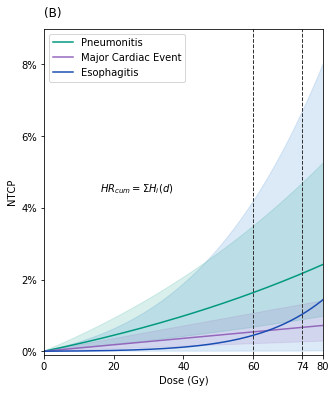

In [8]:
d = np.arange(0,80,.1)
mean = 45
std = 15
tcp = cdf(d, mean, std)
c1 = (.1,.55,.7)
c2 = (.9,.4,.1)
tcp_pdf = pdf(d, mean, std)

r = nsclc.rsi
d = 2
beta = 0.05
# for SF2 alpha
n = 1
alpha_tcc = np.log(r)/(-n*d) - beta*d
rxdose_tcc = 33/(alpha_tcc+beta*d)
rxdose_tcc=rxdose_tcc.values

x,rxdose_pdf,rxdose_cdf = create_kde(rxdose_tcc,bandwidth=.28)

e = H_esoph(x)
p = H_lung(x)

MCE_base = 0.017
c = MCE_base*(1+.074*x/14)-.017
c_upper = MCE_base*(1+.145*x/14)-.017
c_lower = MCE_base*(1+.029*x/14)-.017


fig, ax = plt.subplots(figsize=(5,6))

# ax.plot(x,e*1.2,color=(.1,.3,.7),label='Esophagitis')
ax.fill_between(x,y1=H_esoph(x,'upper')*.9,y2=H_esoph(x,'lower'), color=(.1,.45,.8), alpha=.15)
ax.plot(x,p,color=(0,.6,.5),label='Pneumonitis')
ax.fill_between(x,y1=H_lung(x,CI='upper'),y2=H_lung(x,CI='lower'), color=(0,.6,.5), alpha=.15)
ax.plot(x,c,color=cp[4],label='Major Cardiac Event')
ax.fill_between(x,y1=c_upper,y2=c_lower, color=cp[4], alpha=.15)
ax.plot(x,e*1.2,color=(.1,.3,.7),label='Esophagitis')

ax.axvline(60,c=(.2,.2,.2),lw=1,ls='--')
ax.axvline(74,c=(.2,.2,.2),lw=1,ls='--')

eq_string = r'$HR_{cum} = \Sigma H_{i}(d)$'
ax.text(.2,.5, eq_string, transform=ax.transAxes)

yticks=[0,.02,.04,.06,.08]
ax.set_yticks(yticks)
ax.set_yticklabels(['0%','2%','4%','6%','8%'])
ax.set_ylim(-.001,.09)
ax.set_xticks([0,20,40,60,74,80])
ax.set_xlim(0,80)
ax.set_xlabel('Dose (Gy)')
ax.set_ylabel('NTCP')

ax.set_title('(B)',loc='left',pad=12)
ax.legend()

In [9]:
H_esoph(d)

8.071650865332094e-06

In [10]:
(220+167+36.5)/100000*4

0.01694

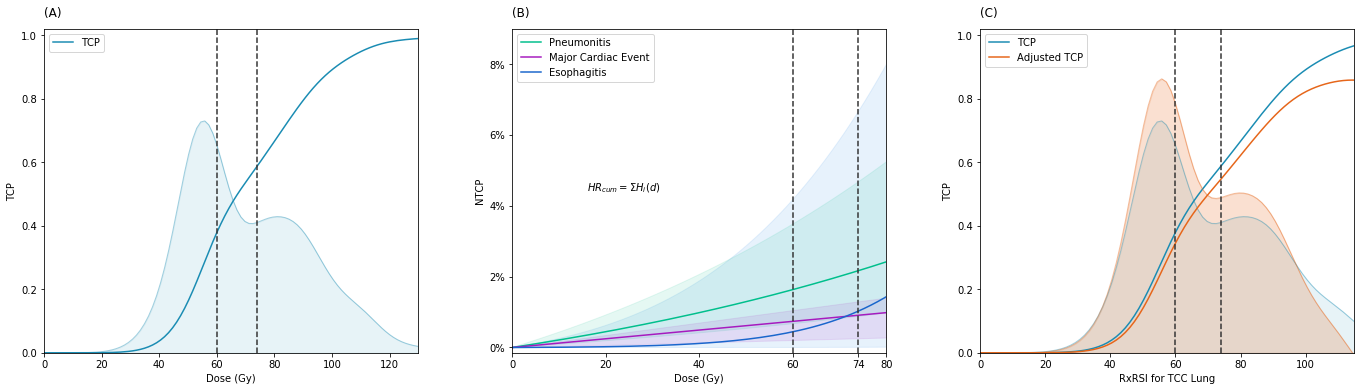

In [11]:
d = np.arange(0,80,.1)
mean = 45
std = 15
tcp = cdf(d, mean, std)
c1 = (.1,.55,.7)
c2 = (.9,.4,.1)
tcp_pdf = pdf(d, mean, std)

r = nsclc.rsi
d = 2
beta = 0.05
# for SF2 alpha
n = 1
alpha_tcc = np.log(r)/(-n*d) - beta*d
rxdose_tcc = 33/(alpha_tcc+beta*d)
rxdose_tcc=rxdose_tcc.values

x,rxdose_pdf,rxdose_cdf = create_kde(rxdose_tcc,bandwidth=.28)

e = H_esoph(x)
p = H_lung(x)
MCE_base = 0.01
c = MCE_base*(1+.16*x/13)-.01

fig, axes = plt.subplots(figsize=(20,6),nrows=1,ncols=3,sharex=False)

"""---------------------------------- first part ----------------------------------"""

ax=axes[0]

ax.plot(x, rxdose_cdf,color=c1,label='TCP')

y=rxdose_pdf*35*.92
ax.fill_between(x,y,color=c1,alpha=.1)
ax.plot(x,y,color=c1,lw=1,alpha=.4)

ax.axvline(60,c=(.2,.2,.2),lw=1.5,ls='--')
ax.axvline(74,c=(.2,.2,.2),lw=1.5,ls='--')

ax.set_xlim(0,130)
ax.set_ylim(0,1.02)
ax.set_ylabel('TCP')
ax.set_xticks([0,20,40,60,80,100,120])
ax.set_xlabel('Dose (Gy)')

ax.set_title('(A)',loc='left',pad=12)
ax.legend()

"""-------------------------- second  plot ----------------------------------"""

ax=axes[1]

ax.fill_between(x,y1=H_esoph(x,'upper')*.9,y2=H_esoph(x,'lower'), color=(.1,.5,.9), alpha=.1)
ax.plot(x,p,color=(0,.75,.55),label='Pneumonitis')
ax.fill_between(x,y1=H_lung(x,CI='upper'),y2=H_lung(x,CI='lower'), color=(0,.75,.55), alpha=.1)
ax.plot(x,c,color=(.65,.1,.75),label='Major Cardiac Event')
ax.fill_between(x,y1=c_upper,y2=c_lower, color=(.65,.1,.75), alpha=.1)

ax.plot(x,e*1.2,color=(.1,.4,.8),label='Esophagitis')

ax.axvline(60,c=(.2,.2,.2),lw=1.5,ls='--')
ax.axvline(74,c=(.2,.2,.2),lw=1.5,ls='--')

eq_string = r'$HR_{cum} = \Sigma H_{i}(d)$'
ax.text(.2,.5, eq_string, transform=ax.transAxes)

yticks=[0,.02,.04,.06,.08]
ax.set_yticks(yticks)
ax.set_yticklabels(['0%','2%','4%','6%','8%'])
ax.set_ylim(-.0015,.09)
ax.set_xticks([0,20,40,60,74,80])
ax.set_xlim(0,80)
ax.set_xlabel('Dose (Gy)')
ax.set_ylabel('NTCP')

ax.set_title('(B)',loc='left',pad=12)
ax.legend()
    
######################################    
"""-------------------------- third  plot ----------------------------------"""
ax=axes[2]


ax.plot(x, rxdose_cdf,color=c1,label='TCP')

y=rxdose_pdf*35*.92
ax.fill_between(x,y,color=c1,alpha=.1)
ax.plot(x,y,color=c1,lw=1,alpha=.4)

y2=np.power(rxdose_cdf*(1-p)*(1-e),1.074)
ax.plot(x[:85],y2[:85],color=c2,label='Adjusted TCP')

y3=np.gradient(y2)*35*.82
ax.fill_between(x,y3,color=c2,alpha=.2)
ax.plot(x,y3,color=c2,lw=1,alpha=.4)

ax.axvline(60,c=(.2,.2,.2),lw=1.5,ls='--')
ax.axvline(74,c=(.2,.2,.2),lw=1.5,ls='--')

ax.set_xlim(0,115)
ax.set_ylim(0,1.02)
ax.set_ylabel('TCP')
ax.set_xticks([0,20,40,60,80,100])
ax.set_xlabel('Dose (Gy)')

ax.set_title('(C)',loc='left',pad=12)
ax.legend()

ax.set_xlabel('RxRSI for TCC Lung')

    
fig.subplots_adjust(left=.06,right=.97,bottom=.15,top=.9,wspace=.25)

# plt.savefig('/Users/geoffreysedor/gui_app/Supplemental/Figures'+'fig2_may', dpi =300) #, edgecolor='black', linewidth=4)